In [1]:
import os 
os.chdir('C:/Users/jonat/Desktop/project.sub.ner/')

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
print(keras.__version__)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from math import nan
from keras.callbacks import ModelCheckpoint
from keras_contrib.layers import CRF

Using TensorFlow backend.


2.3.1


In [3]:
df = pd.read_csv("csv/final.df.csv", encoding = "ISO-8859-1", error_bad_lines=False)
df=df.drop(['token_upos', 'sent_upos', 'freq.verb', 'freq.noun', 'freq.adj'],axis=1)
df.columns = ['sentence_idx', 'word', 'tag']
print(df.head())

   sentence_idx       word    tag
0             3          -  PUNCT
1             3         ek   PRON
2             3       dink   NOUN
3             3  hiernatoe   PRON
4             3        nee   VERB


In [4]:
print(df.shape)
print(df['tag'].value_counts())

(109987, 3)
PRON     18458
NOUN     16353
PUNCT    10967
VERB     10826
AUX      10788
ADV       9145
ADP       8666
DET       7963
ADJ       6491
CCONJ     3145
PART      2689
SCONJ     2653
NUM        767
SYM        566
X          484
PROPN       26
Name: tag, dtype: int64


In [5]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
          
getter = SentenceGetter(df)
sentences = getter.sentences

In [6]:
print(sentences[2])

[('maar', 'CCONJ'), ('hy', 'PRON'), ('is', 'AUX'), ('hardekop', 'VERB'), ('en', 'CCONJ'), ('dislojaal', 'VERB'), ('wat', 'PRON'), ('meer', 'DET'), ('is', 'AUX'), (',', 'PUNCT'), ('hy', 'PRON'), ('verteenwoordig', 'VERB'), ("'n", 'DET'), ('baie', 'DET'), ('sterk', 'ADJ'), ('groep', 'NOUN'), ('hy', 'PRON'), ('is', 'AUX'), ('die', 'DET'), ('hoof', 'NOUN'), ('van', 'ADP'), ('die', 'DET'), ('sterkste', 'ADJ'), ('weerstandsgroep', 'NOUN'), ('in', 'ADP'), ('die', 'DET'), ('land', 'NOUN'), ('dis', 'ADV'), ('hoekom', 'AUX'), ('ek', 'PRON'), ('met', 'ADP'), ('hom', 'PRON'), ('wil', 'AUX'), ('praat', 'VERB'), ('daar', 'PRON'), ('moet', 'AUX'), ("'n", 'DET'), ('manier', 'NOUN'), ('wees', 'AUX'), ('om', 'ADP'), ('mekaar', 'PRON'), ('te', 'PART'), ('kan', 'AUX'), ('verstaan', 'VERB'), ('u', 'PRON'), ('koninglike', 'ADJ'), ('hoogheid', 'NOUN'), ('sien', 'VERB'), ('alreeds', 'ADV'), ('dat', 'SCONJ'), ('hy', 'PRON'), ('selfs', 'ADV'), ('die', 'DET'), ('uitnodiging', 'NOUN'), ('van', 'ADP'), ('sy', 'PRO

In [7]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 415


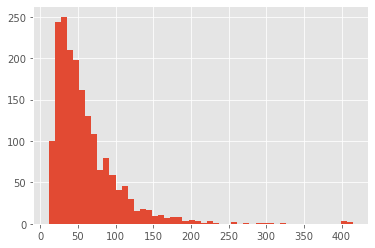

In [8]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [9]:
from math import nan

words = list(set(df["word"].values))
words.append("ENDPAD")
n_words = len(words)
print(n_words)

tags = []
for tag in set(df["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)
print(n_tags)

10049
16


In [10]:
from future.utils import iteritems

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [11]:
print(dict(list(word2idx.items())[0:2]))
print(dict(list(tag2idx.items())[0:2]))
print(dict(list(idx2tag.items())[0:2]))

{'getriomfeer': 0, 'afgeskiet': 1}
{'ADP': 0, 'SCONJ': 1}
{0: 'ADP', 1: 'SCONJ'}


In [34]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

maxlen = max([len(s) for s in sentences])

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)
print("X size: ", X.size)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx['VERB'])
y = [to_categorical(i, num_classes=n_tags) for i in y]
print("y size: ", len(y))

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(len(y_train))

X size:  764845
y size:  1843
(1474, 415)
1474


In [35]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras import regularizers
import keras as k
from keras_contrib.layers import CRF

input = Input(shape=(X_train.shape[1],))
word_embedding_size = 300

# Embedding Layer
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=X_train.shape[1])(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  

# CRF Layer
crf = CRF(n_tags)

out = crf(model)  # output
model = Model(input, out)

In [36]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
adam = k.optimizers.Adam(learning_rate=0.006, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

model.summary()

# Saving the best model only
filepath="ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the best model
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=10, validation_split=0.2, verbose=1, callbacks=callbacks_list)

C:\Users\jonat\Anaconda3\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\jonat\Anaconda3\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 415)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 415, 300)          3014700   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 415, 600)          1442400   
_________________________________________________________________
lstm_6 (LSTM)                (None, 415, 600)          2882400   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 415, 16)           9616      
_________________________________________________________________
crf_3 (CRF)                  (None, 415, 16)           560       
Total params: 7,349,676
Trainable params: 7,349,676
Non-trainable params: 0
_________________________________________________

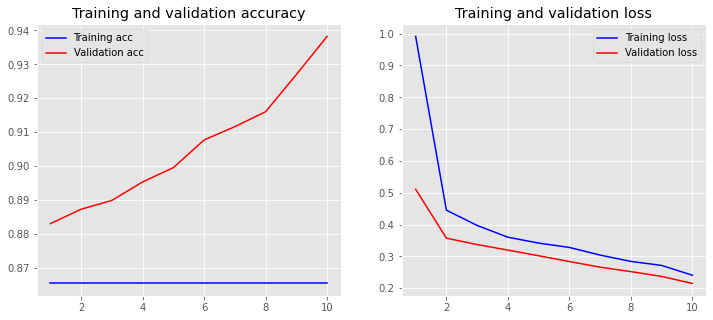

In [28]:
# Plot the graph 
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [29]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

369/369 [==============================] - 114s 310ms/step


In [32]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 48.7%


In [33]:
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

C:\Users\jonat\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         ADJ       0.44      0.06      0.11      1296
         ADP       0.99      0.99      0.99    132924
         ADV       0.33      0.01      0.03      1893
         AUX       0.45      0.54      0.49      2136
       CCONJ       0.00      0.00      0.00       647
         DET       0.80      0.85      0.82      1537
        NOUN       0.54      0.77      0.63      3210
         NUM       0.00      0.00      0.00       173
        PART       0.00      0.00      0.00       560
        PRON       0.50      0.87      0.63      3627
       PROPN       0.00      0.00      0.00         2
       PUNCT       0.57      0.75      0.65      2233
       SCONJ       0.00      0.00      0.00       526
         SYM       0.00      0.00      0.00       122
        VERB       0.42      0.36      0.38      2126
           X       0.00      0.00      0.00       123

    accuracy                           0.93    153135
   macro avg       0.31   

In [20]:
TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1

In [21]:
for i, sentence in enumerate(X_test):
    y_hat = np.argmax(test_pred[0], axis=-1)
    gt = np.argmax(y_test[0], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
        accumulate_score_by_tag(idx2tag[gt[idx]],tags[pred])

In [22]:
for tag in tag2idx.keys():
    print(f'tag:{tag}')    
    print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
    print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))   

tag:ADP
	 TN:      1107	FP:         0
	 FN:         0	TP:         0
tag:SCONJ
	 TN:      1107	FP:         0
	 FN:         0	TP:    141327
tag:X
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:AUX
	 TN:      1107	FP:         0
	 FN:         0	TP:         0
tag:PROPN
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:PART
	 TN:       369	FP:         0
	 FN:         0	TP:         0
tag:NUM
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:VERB
	 TN:      1107	FP:         0
	 FN:         0	TP:         0
tag:CCONJ
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:SYM
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:ADV
	 TN:       738	FP:         0
	 FN:         0	TP:         0
tag:NOUN
	 TN:       738	FP:         0
	 FN:         0	TP:       369
tag:DET
	 TN:      1107	FP:         0
	 FN:         0	TP:         0
tag:PUNCT
	 TN:       738	FP:         0
	 FN:         0	TP:       369
tag:PRON
	 TN:      1476	FP:         0
